In [2]:
import os
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import numpy as np
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
sns.set()
import optuna


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
EPOCHS = 10
N_TRIALS = 10  # Number of Optuna trials
def prepare_data(dire):
    total_images = 1600
    signLang = ['accident', 'call', 'doctor', 'help', 'hot', 'lose', 'pain', 'thief']
    X = list(np.zeros(shape=(total_images , 128, 128)))
    y = list(np.zeros(shape=(total_images)))
    i=0
    cnt = 0
    y_value = 0
    for sign in signLang : 
        available_images = gb.glob(pathname= dire + f'{sign}/*.png')
        for image in available_images : 
            try : 
                if cnt == 200:
                    continue
                x = plt.imread(image)
                x = cv2.resize(x, (128, 128))

                X[i] = x
                y[i] = y_value
                i+=1
                cnt+=1
                    
            except : 
                pass
            
        y_value+=1
        cnt = 0
    ohe  = OneHotEncoder()
    y = np.array(y)
    y = y.reshape(len(y), 1)
    ohe.fit(y)
    y = ohe.transform(y).toarray()
    X = np.array(X)
    print(f'X shape is {X.shape}')
    print(f'y shape is {y.shape}')
    return X, y

In [4]:
def create_cnn_model(input_shape, num_classes, trial=None):
    model = Sequential()
    ################
    model.add(Conv2D(trial.suggest_int("conv_units1", 256, 512),
                     kernel_size=(3, 3),activation="relu",input_shape=input_shape,))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    ################
    model.add(Conv2D(trial.suggest_int("conv_units2", 128, 256),
                     kernel_size=(3, 3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #################
    model.add(Conv2D(trial.suggest_int("conv_units3", 64, 128),
                     kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #################
    model.add(Flatten())
    model.add(Dense(trial.suggest_int("dense_units1", 64, 128), activation="relu"))
    model.add(Dropout(trial.suggest_float("dropout", 0.1, 0.5)))
    ###################
    model.add(Dense(trial.suggest_int("dense_units2", 32, 64), activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    
    return model

In [5]:
def objective(trial):
    input_dir = "/kaggle/input/emergency-sign-language/Image_Data/"
    log_dir = "Logs"
    X, y = prepare_data(input_dir)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    model = create_cnn_model(input_shape, num_classes, trial)

    model.compile(
        optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"]
    )

    tb_callback = TensorBoard(log_dir=log_dir)
    model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=EPOCHS, callbacks=[tb_callback], verbose=1, batch_size = 32)

    res = model.predict(X_test)
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(res, axis=1).tolist()

    acc = accuracy_score(ytrue, yhat)
    precision = precision_score(ytrue, yhat, average='weighted')
    recall = recall_score(ytrue, yhat, average='weighted')
    f1 = f1_score(ytrue, yhat, average='weighted')
    conf_matrix = confusion_matrix(ytrue, yhat)

    # Display the metrics
    print("Accuracy", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return acc

### Model Folder

In [6]:
input_dir = "/kaggle/input/emergency-sign-language/Image_Data/"
model_dir = "Models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Running Optuna Hyperparamer Tunning 

In [7]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=N_TRIALS)  # Change number of trials here

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-09-01 15:30:14,949] A new study created in memory with name: no-name-a3686683-335a-4b37-bad0-ea76b9c0457f


X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 14s 67ms/step - loss: 2.0906 - categorical_accuracy: 0.1437 - val_loss: 2.0121 - val_categorical_accuracy: 0.1813
Epoch 2/10
40/40 [==============================] - 2s 62ms/step - loss: 1.7667 - categorical_accuracy: 0.2969 - val_loss: 1.2360 - val_categorical_accuracy: 0.5156
Epoch 3/10
40/40 [==============================] - 2s 62ms/step - loss: 1.3710 - categorical_accuracy: 0.4445 - val_loss: 0.9302 - val_categorical_accuracy: 0.7156
Epoch 4/10
40/40 [==============================] - 2s 58ms/step - loss: 0.9953 - categorical_accuracy: 0.5883 - val_loss: 0.6489 - val_categorical_accuracy: 0.7312
Epoch 5/10
40/40 [==============================] - 2s 58ms/step - loss: 0.7095 - categorical_accuracy: 0.7000 - val_loss: 0.4705 - val_categorical_accuracy: 0.8313
Epoch 6/10
40/40 [==============================] - 2s 58ms/step - loss: 0.5658 - categorical_accuracy: 0.7930 - val_loss:

[I 2023-09-01 15:31:16,849] Trial 0 finished with value: 0.934375 and parameters: {'conv_units1': 329, 'conv_units2': 150, 'conv_units3': 107, 'dense_units1': 85, 'dropout': 0.45187297611584054, 'dense_units2': 58}. Best is trial 0 with value: 0.934375.


Accuracy 0.934375
Precision: 0.9332295938491916
Recall: 0.934375
F1 Score: 0.9330680528443857
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 38  0  0  5  5  0  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  5  0  0 27  0  3  0]
 [ 0  0  1  0  0 42  1  0]
 [ 0  1  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 8s 76ms/step - loss: 2.0479 - categorical_accuracy: 0.1672 - val_loss: 1.8067 - val_categorical_accuracy: 0.4156
Epoch 2/10
40/40 [==============================] - 3s 69ms/step - loss: 1.5353 - categorical_accuracy: 0.4555 - val_loss: 0.9147 - val_categorical_accuracy: 0.7000
Epoch 3/10
40/40 [==============================] - 3s 72ms/step - loss: 0.8832 - categorical_accuracy: 0.6805 - val_loss: 0.5016 - val_categorical_accuracy: 0.8625
Epoch 4/10
40/40 [==============================] - 3s 72ms/step - loss: 0.5564 - categorical_accuracy: 0.7914 - val_loss: 

[I 2023-09-01 15:32:05,462] Trial 1 finished with value: 0.95 and parameters: {'conv_units1': 426, 'conv_units2': 188, 'conv_units3': 84, 'dense_units1': 73, 'dropout': 0.3112287179150909, 'dense_units2': 40}. Best is trial 1 with value: 0.95.


Accuracy 0.95
Precision: 0.953125
Recall: 0.95
F1 Score: 0.9504716158079611
Confusion Matrix:
 [[40  0  0  0  1  0  0  0]
 [ 0 43  0  0  3  0  2  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  3  0  0 31  0  1  0]
 [ 0  1  0  0  0 39  4  0]
 [ 0  1  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 9s 84ms/step - loss: 2.0845 - categorical_accuracy: 0.1305 - val_loss: 2.0496 - val_categorical_accuracy: 0.2125
Epoch 2/10
40/40 [==============================] - 3s 76ms/step - loss: 1.8024 - categorical_accuracy: 0.2992 - val_loss: 1.3121 - val_categorical_accuracy: 0.5125
Epoch 3/10
40/40 [==============================] - 3s 74ms/step - loss: 1.3401 - categorical_accuracy: 0.4594 - val_loss: 0.9213 - val_categorical_accuracy: 0.6781
Epoch 4/10
40/40 [==============================] - 3s 76ms/step - loss: 1.0790 - categorical_accuracy: 0.5547 - val_loss: 0.7252 - val_categ

[I 2023-09-01 15:32:54,290] Trial 2 finished with value: 0.915625 and parameters: {'conv_units1': 408, 'conv_units2': 228, 'conv_units3': 85, 'dense_units1': 79, 'dropout': 0.4621106920995808, 'dense_units2': 32}. Best is trial 1 with value: 0.95.


Accuracy 0.915625
Precision: 0.9174426578471302
Recall: 0.915625
F1 Score: 0.9157609005600305
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 40  0  0  4  1  3  0]
 [ 0  0 47  0  0  0  0  0]
 [ 1  0  0 34  0  0  0  0]
 [ 0  4  0  0 27  0  4  0]
 [ 0  2  0  0  1 39  0  2]
 [ 0  5  0  0  0  0 31  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 7s 61ms/step - loss: 2.0056 - categorical_accuracy: 0.1891 - val_loss: 1.7492 - val_categorical_accuracy: 0.3063
Epoch 2/10
40/40 [==============================] - 2s 58ms/step - loss: 1.5010 - categorical_accuracy: 0.4039 - val_loss: 1.1709 - val_categorical_accuracy: 0.5719
Epoch 3/10
40/40 [==============================] - 2s 58ms/step - loss: 1.0632 - categorical_accuracy: 0.5562 - val_loss: 0.7766 - val_categorical_accuracy: 0.6531
Epoch 4/10
40/40 [==============================] - 2s 58ms/step - loss: 0.8395 - categorical_accuracy: 0.6625 - val_loss: 

[I 2023-09-01 15:33:42,793] Trial 3 finished with value: 0.915625 and parameters: {'conv_units1': 317, 'conv_units2': 166, 'conv_units3': 71, 'dense_units1': 68, 'dropout': 0.11281271850025881, 'dense_units2': 57}. Best is trial 1 with value: 0.95.


Accuracy 0.915625
Precision: 0.9311294934640524
Recall: 0.915625
F1 Score: 0.9179258545039488
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 39  0  0  7  0  2  0]
 [ 0  0 47  0  0  0  0  0]
 [ 1  0  0 34  0  0  0  0]
 [ 0  0  0  0 33  0  2  0]
 [ 3  1  0  0  3 36  1  0]
 [ 0  0  0  0  7  0 29  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 9s 83ms/step - loss: 2.0753 - categorical_accuracy: 0.1656 - val_loss: 1.9408 - val_categorical_accuracy: 0.1656
Epoch 2/10
40/40 [==============================] - 3s 73ms/step - loss: 1.4740 - categorical_accuracy: 0.4203 - val_loss: 0.9552 - val_categorical_accuracy: 0.6562
Epoch 3/10
40/40 [==============================] - 3s 76ms/step - loss: 0.8592 - categorical_accuracy: 0.6570 - val_loss: 0.6660 - val_categorical_accuracy: 0.7531
Epoch 4/10
40/40 [==============================] - 3s 74ms/step - loss: 0.5344 - categorical_accuracy: 0.8086 - val_loss: 

[I 2023-09-01 15:34:25,234] Trial 4 finished with value: 0.975 and parameters: {'conv_units1': 455, 'conv_units2': 165, 'conv_units3': 101, 'dense_units1': 85, 'dropout': 0.11012839701074612, 'dense_units2': 37}. Best is trial 4 with value: 0.975.


Accuracy 0.975
Precision: 0.9771659044715447
Recall: 0.975
F1 Score: 0.9752729268570335
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 44  0  0  1  0  3  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  0  0  0 33  0  2  0]
 [ 0  0  0  0  2 42  0  0]
 [ 0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 8s 81ms/step - loss: 1.8921 - categorical_accuracy: 0.2430 - val_loss: 1.3409 - val_categorical_accuracy: 0.4938
Epoch 2/10
40/40 [==============================] - 3s 71ms/step - loss: 0.9581 - categorical_accuracy: 0.6195 - val_loss: 0.5652 - val_categorical_accuracy: 0.7906
Epoch 3/10
40/40 [==============================] - 3s 71ms/step - loss: 0.4665 - categorical_accuracy: 0.8289 - val_loss: 0.3133 - val_categorical_accuracy: 0.8844
Epoch 4/10
40/40 [==============================] - 3s 74ms/step - loss: 0.2950 - categorical_accuracy: 0.8992 - val_loss: 0.2203

[I 2023-09-01 15:35:13,691] Trial 5 finished with value: 0.978125 and parameters: {'conv_units1': 480, 'conv_units2': 130, 'conv_units3': 82, 'dense_units1': 123, 'dropout': 0.17962082152582304, 'dense_units2': 43}. Best is trial 5 with value: 0.978125.


Accuracy 0.978125
Precision: 0.9799264705882355
Recall: 0.978125
F1 Score: 0.9780517637677081
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  2  0  0 31  0  2  0]
 [ 0  1  0  0  0 41  2  0]
 [ 0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 11s 97ms/step - loss: 2.0825 - categorical_accuracy: 0.1672 - val_loss: 1.9452 - val_categorical_accuracy: 0.4031
Epoch 2/10
40/40 [==============================] - 4s 89ms/step - loss: 1.5068 - categorical_accuracy: 0.4273 - val_loss: 0.8452 - val_categorical_accuracy: 0.7063
Epoch 3/10
40/40 [==============================] - 4s 89ms/step - loss: 0.8707 - categorical_accuracy: 0.6539 - val_loss: 0.5921 - val_categorical_accuracy: 0.7281
Epoch 4/10
40/40 [==============================] - 4s 90ms/step - loss: 0.6412 - categorical_accuracy: 0.7477 - val_loss:

[I 2023-09-01 15:36:43,602] Trial 6 finished with value: 0.9625 and parameters: {'conv_units1': 493, 'conv_units2': 226, 'conv_units3': 90, 'dense_units1': 94, 'dropout': 0.35588488160245846, 'dense_units2': 62}. Best is trial 5 with value: 0.978125.


Accuracy 0.9625
Precision: 0.964578536412418
Recall: 0.9625
F1 Score: 0.9626010155590912
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 1 43  0  0  4  0  0  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  1  0  0 32  0  2  0]
 [ 0  0  0  1  2 40  1  0]
 [ 0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 7s 68ms/step - loss: 2.0533 - categorical_accuracy: 0.1867 - val_loss: 1.8053 - val_categorical_accuracy: 0.5031
Epoch 2/10
40/40 [==============================] - 3s 63ms/step - loss: 1.4484 - categorical_accuracy: 0.4523 - val_loss: 0.8951 - val_categorical_accuracy: 0.6656
Epoch 3/10
40/40 [==============================] - 2s 61ms/step - loss: 0.8587 - categorical_accuracy: 0.6711 - val_loss: 0.5328 - val_categorical_accuracy: 0.7688
Epoch 4/10
40/40 [==============================] - 3s 65ms/step - loss: 0.6142 - categorical_accuracy: 0.7648 - val_loss: 0.435

[I 2023-09-01 15:37:19,749] Trial 7 finished with value: 0.95625 and parameters: {'conv_units1': 370, 'conv_units2': 163, 'conv_units3': 87, 'dense_units1': 117, 'dropout': 0.454585071134605, 'dense_units2': 42}. Best is trial 5 with value: 0.978125.


Accuracy 0.95625
Precision: 0.9593543667466987
Recall: 0.95625
F1 Score: 0.9564798060909876
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 45  0  0  2  0  1  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  1  0  0 31  0  3  0]
 [ 0  2  0  0  1 38  3  0]
 [ 0  1  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 34]]
X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 10s 96ms/step - loss: 2.0807 - categorical_accuracy: 0.1469 - val_loss: 2.0329 - val_categorical_accuracy: 0.3406
Epoch 2/10
40/40 [==============================] - 4s 89ms/step - loss: 1.7201 - categorical_accuracy: 0.3477 - val_loss: 1.2093 - val_categorical_accuracy: 0.5875
Epoch 3/10
40/40 [==============================] - 4s 89ms/step - loss: 1.0789 - categorical_accuracy: 0.5695 - val_loss: 0.7074 - val_categorical_accuracy: 0.7625
Epoch 4/10
40/40 [==============================] - 3s 87ms/step - loss: 0.7284 - categorical_accuracy: 0.7188 - val_loss: 0

[I 2023-09-01 15:38:49,568] Trial 8 finished with value: 0.9375 and parameters: {'conv_units1': 475, 'conv_units2': 229, 'conv_units3': 99, 'dense_units1': 82, 'dropout': 0.44061688971294277, 'dense_units2': 34}. Best is trial 5 with value: 0.978125.


X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 9s 84ms/step - loss: 1.8591 - categorical_accuracy: 0.2781 - val_loss: 1.1660 - val_categorical_accuracy: 0.5281
Epoch 2/10
40/40 [==============================] - 3s 73ms/step - loss: 0.9122 - categorical_accuracy: 0.6578 - val_loss: 0.4991 - val_categorical_accuracy: 0.8094
Epoch 3/10
40/40 [==============================] - 3s 73ms/step - loss: 0.4735 - categorical_accuracy: 0.8273 - val_loss: 0.4249 - val_categorical_accuracy: 0.8375
Epoch 4/10
40/40 [==============================] - 3s 70ms/step - loss: 0.2988 - categorical_accuracy: 0.8938 - val_loss: 0.2825 - val_categorical_accuracy: 0.9094
Epoch 5/10
40/40 [==============================] - 3s 72ms/step - loss: 0.2166 - categorical_accuracy: 0.9211 - val_loss: 0.2567 - val_categorical_accuracy: 0.9062
Epoch 6/10
40/40 [==============================] - 3s 70ms/step - loss: 0.1428 - categorical_accuracy: 0.9492 - val_loss: 

[I 2023-09-01 15:39:38,094] Trial 9 finished with value: 0.95 and parameters: {'conv_units1': 374, 'conv_units2': 215, 'conv_units3': 97, 'dense_units1': 119, 'dropout': 0.23253075501401055, 'dense_units2': 57}. Best is trial 5 with value: 0.978125.


Accuracy 0.95
Precision: 0.9522975127551021
Recall: 0.95
F1 Score: 0.9498567190386742
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 45  0  0  3  0  0  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  2  0  0 28  0  5  0]
 [ 0  1  0  0  1 39  2  1]
 [ 0  1  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 34]]
Number of finished trials:  10
Best trial:
Value:  0.978125
Params: 
    conv_units1: 480
    conv_units2: 130
    conv_units3: 82
    dense_units1: 123
    dropout: 0.17962082152582304
    dense_units2: 43


### Training The Best Model

In [8]:
X, y = prepare_data(input_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model = create_cnn_model(X_train.shape[1:], y_train.shape[1], trial)
best_model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"]
)
history = best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size= 32, validation_data = [X_test, y_test])

X shape is (1600, 128, 128, 3)
y shape is (1600, 8)
Epoch 1/10
40/40 [==============================] - 5s 81ms/step - loss: 1.9014 - categorical_accuracy: 0.2328 - val_loss: 1.3707 - val_categorical_accuracy: 0.4750
Epoch 2/10
40/40 [==============================] - 3s 71ms/step - loss: 0.9096 - categorical_accuracy: 0.6516 - val_loss: 0.5461 - val_categorical_accuracy: 0.7844
Epoch 3/10
40/40 [==============================] - 3s 71ms/step - loss: 0.4701 - categorical_accuracy: 0.8289 - val_loss: 0.3868 - val_categorical_accuracy: 0.8500
Epoch 4/10
40/40 [==============================] - 3s 74ms/step - loss: 0.3112 - categorical_accuracy: 0.8859 - val_loss: 0.3925 - val_categorical_accuracy: 0.8562
Epoch 5/10
40/40 [==============================] - 3s 74ms/step - loss: 0.2357 - categorical_accuracy: 0.9273 - val_loss: 0.1704 - val_categorical_accuracy: 0.9438
Epoch 6/10
40/40 [==============================] - 3s 74ms/step - loss: 0.1220 - categorical_accuracy: 0.9578 - val_loss: 

### Evaluation

In [9]:
res = best_model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(res, axis=1).tolist()

acc = accuracy_score(ytrue, yhat)
precision = precision_score(ytrue, yhat, average='weighted')
recall = recall_score(ytrue, yhat, average='weighted')
f1 = f1_score(ytrue, yhat, average='weighted')
conf_matrix = confusion_matrix(ytrue, yhat)

# Display the metrics
print("Accuracy", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

10/10 [==============================] - 0s 21ms/step
Accuracy 0.978125
Precision: 0.9798816782810686
Recall: 0.978125
F1 Score: 0.9782770682978944
Confusion Matrix:
 [[41  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  1  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  0  0  0 32  1  2  0]
 [ 0  1  0  0  0 41  2  0]
 [ 0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0 34]]


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(ytrue, yhat)))
print("\nClassification Report : ")
print(classification_report(ytrue, yhat))
print("\nConfusion Matrix : ")
print(confusion_matrix(ytrue, yhat))

Test Accuracy : 0.978125

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.98      0.98      0.98        48
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        35
           4       1.00      0.91      0.96        35
           5       0.98      0.93      0.95        44
           6       0.88      1.00      0.94        36
           7       1.00      1.00      1.00        34

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320


Confusion Matrix : 
[[41  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  1  0]
 [ 0  0 47  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  0  0  0 32  1  2  0]
 [ 0  1  0  0  0 41  2  0]
 [ 0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0 34]]


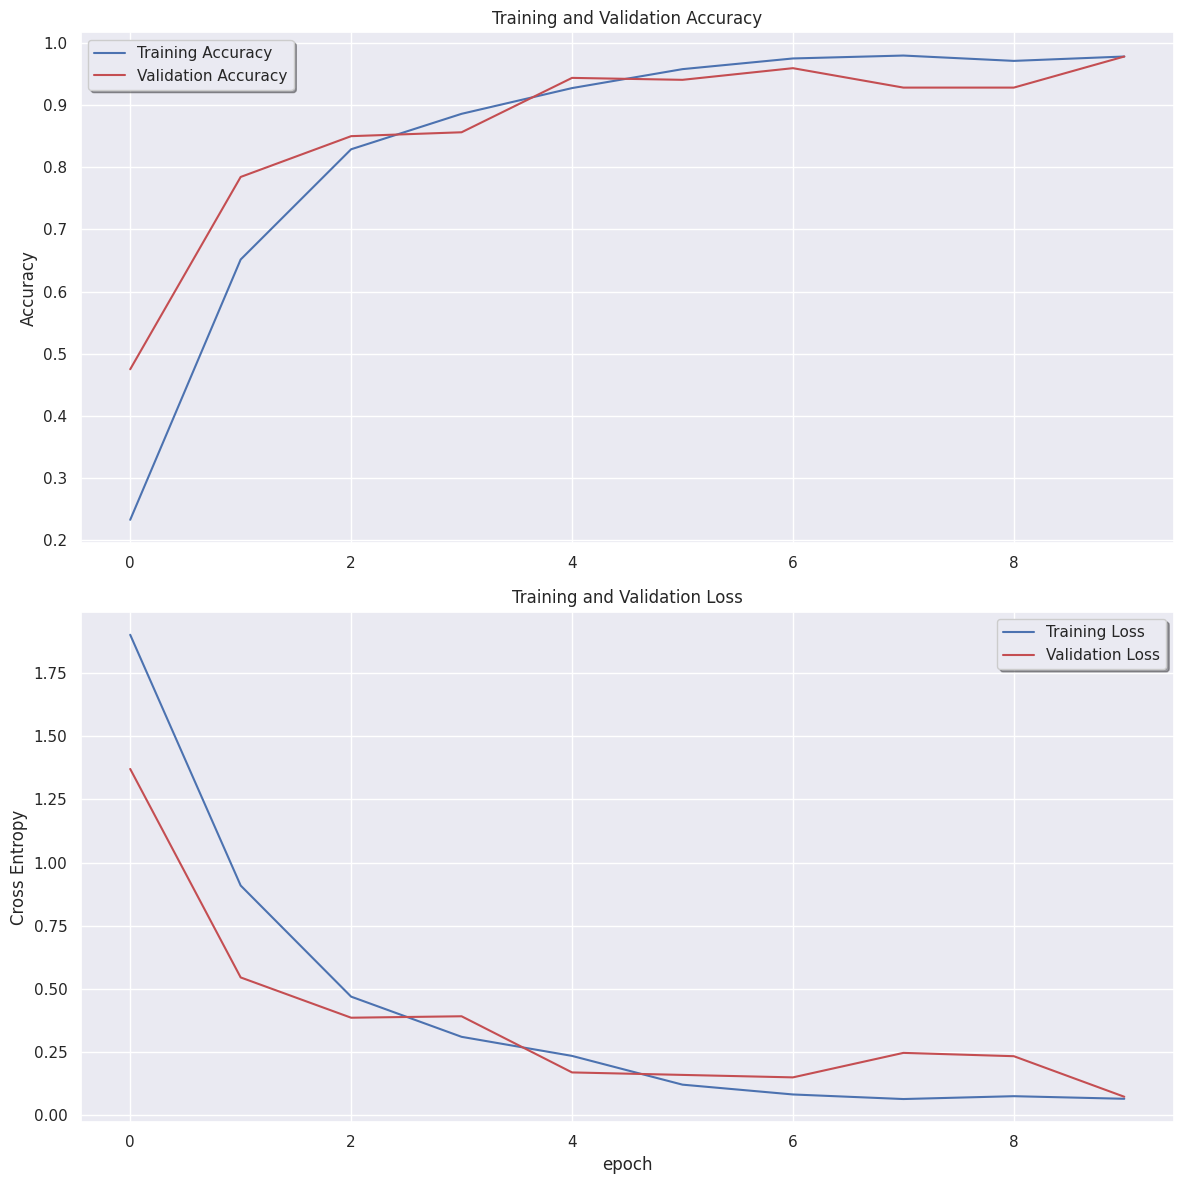

<Figure size 640x480 with 0 Axes>

In [11]:
sns.set()
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(acc,color='b', label='Training Accuracy')
ax1.plot(val_acc,color='r', label='Validation Accuracy')
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(loss,color='b', label='Training Loss')
ax2.plot(val_loss,color='r', label='Validation Loss')
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('Cross Entropy')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')
plt.tight_layout()

plt.show()
plt.savefig('Accuracy.png')

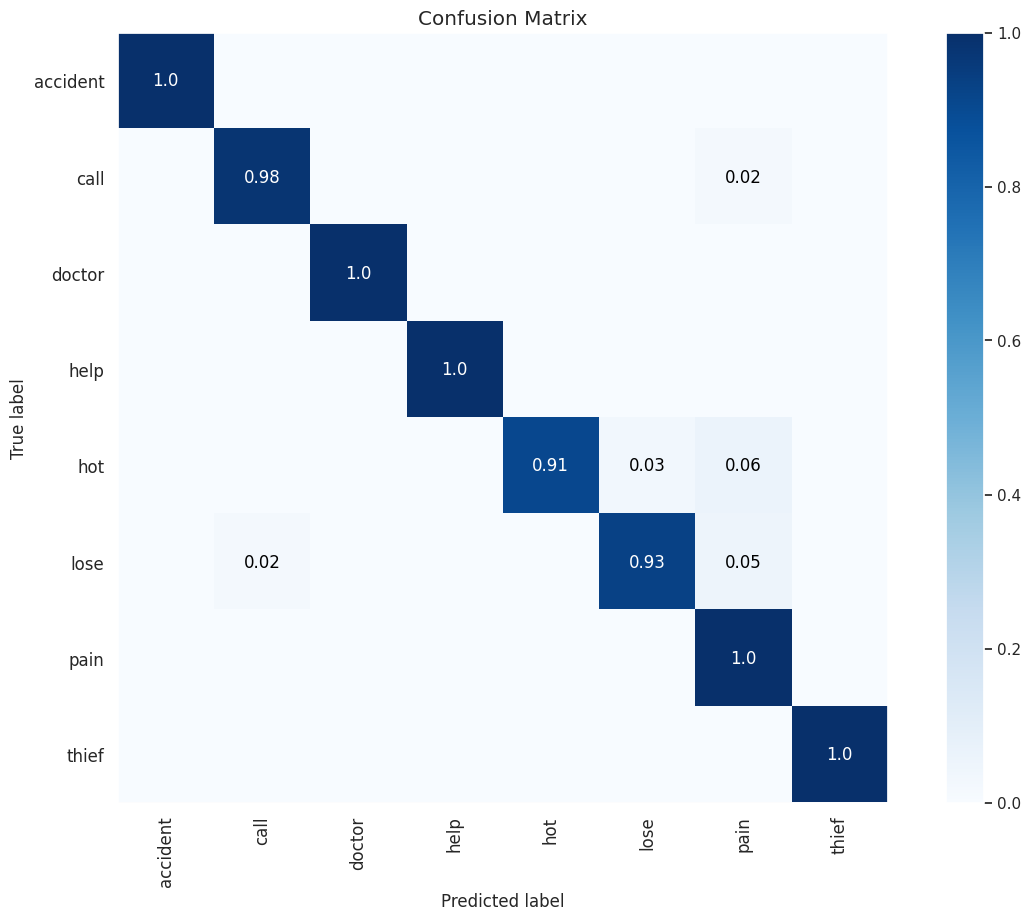

In [12]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
target_classes = ['accident', 'call', 'doctor', 'help', 'hot', 'lose', 'pain', 'thief']

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in ytrue], [target_classes[i] for i in yhat],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(15,10)
                                    );
plt.xticks(rotation=90);

In [13]:
best_model.save(os.path.join(model_dir, "best_cnn_model.h5"))